**Chapter 14 – Recurrent Neural Networks**

_This notebook contains all the sample code and solutions to the exercices in chapter 14._

# Setup

First, let's make sure this notebook works well in both python 2 and 3, import a few common modules, ensure MatplotLib plots figures inline and prepare a function to save the figures:

In [1]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import numpy.random as rnd
import os

# to make this notebook's output stable across runs
rnd.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "rnn"

def save_fig(fig_id, tight_layout=True):
    path = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID, fig_id + ".png")
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)

Then of course we will need TensorFlow:

In [2]:
import tensorflow as tf

# Basic RNNs

## Manual RNN

In [3]:
tf.reset_default_graph()

n_inputs = 3
n_neurons = 5

X0 = tf.placeholder(tf.float32, [None, n_inputs])
X1 = tf.placeholder(tf.float32, [None, n_inputs])

Wx = tf.Variable(tf.random_normal(shape=[n_inputs, n_neurons],dtype=tf.float32))
Wy = tf.Variable(tf.random_normal(shape=[n_neurons,n_neurons],dtype=tf.float32))
b = tf.Variable(tf.zeros([1, n_neurons], dtype=tf.float32))

Y0 = tf.tanh(tf.matmul(X0, Wx) + b)
Y1 = tf.tanh(tf.matmul(Y0, Wy) + tf.matmul(X1, Wx) + b)

init = tf.global_variables_initializer()

In [4]:
import numpy as np

X0_batch = np.array([[0, 1, 2], [3, 4, 5], [6, 7, 8], [9, 0, 1]]) # t = 0
X1_batch = np.array([[9, 8, 7], [0, 0, 0], [6, 5, 4], [3, 2, 1]]) # t = 1

with tf.Session() as sess:
    init.run()
    Y0_val, Y1_val = sess.run([Y0, Y1], feed_dict={X0: X0_batch, X1: X1_batch})

In [5]:
print(Y0_val)

[[ 0.96223319  0.54390049  0.99944168  0.22135893  0.95317668]
 [ 0.99987721  0.9999615   0.99999988 -0.12834749  1.00000012]
 [ 0.99999964  1.          1.         -0.4488056   1.        ]
 [-0.27392432  1.         -0.99962711  0.78032929  1.        ]]


In [6]:
print(Y1_val)

[[ 0.99999964  1.          1.         -0.34297404  1.        ]
 [ 0.30002448 -0.90767932  0.26926002  0.95352989  0.05459169]
 [ 0.99859399  0.99999899  0.99954653  0.86539894  1.        ]
 [ 0.99212319  0.99994123  0.97276199 -0.87521726  0.99968809]]


## Using `rnn()`

In [7]:
tf.reset_default_graph()

n_inputs = 3
n_neurons = 5

In [8]:
X0 = tf.placeholder(tf.float32, [None, n_inputs])
X1 = tf.placeholder(tf.float32, [None, n_inputs])

basic_cell = tf.contrib.rnn.BasicRNNCell(num_units=n_neurons)
output_seqs, states = tf.contrib.rnn.static_rnn(basic_cell, [X0, X1],
                                                dtype=tf.float32)
Y0, Y1 = output_seqs

In [9]:
init = tf.global_variables_initializer()

In [10]:
X0_batch = np.array([[0, 1, 2], [3, 4, 5], [6, 7, 8], [9, 0, 1]])
X1_batch = np.array([[9, 8, 7], [0, 0, 0], [6, 5, 4], [3, 2, 1]])

with tf.Session() as sess:
    init.run()
    Y0_val, Y1_val = sess.run([Y0, Y1], feed_dict={X0: X0_batch, X1: X1_batch})

In [11]:
Y0_val

array([[-0.01483451, -0.49605229,  0.75308919, -0.78006792, -0.14246999],
       [-0.41594887, -0.95152193,  0.99829108, -0.94347018, -0.99635023],
       [-0.70174533, -0.99634278,  0.99998957, -0.98639774, -0.99999106],
       [-0.99520677,  0.84450072,  0.989519  ,  0.99703455, -0.99995816]], dtype=float32)

In [12]:
Y1_val

array([[-0.95365602, -0.999026  ,  0.99998683, -0.81465274, -1.        ],
       [-0.62058419, -0.08800258, -0.88539422, -0.46115425,  0.67685097],
       [-0.91839862, -0.9652319 ,  0.99197757, -0.70452976, -0.9999088 ],
       [-0.51075095, -0.0602669 ,  0.81636053, -0.57558066, -0.92382717]], dtype=float32)

In [13]:
from IPython.display import clear_output, Image, display, HTML

def strip_consts(graph_def, max_const_size=32):
    """Strip large constant values from graph_def."""
    strip_def = tf.GraphDef()
    for n0 in graph_def.node:
        n = strip_def.node.add() 
        n.MergeFrom(n0)
        if n.op == 'Const':
            tensor = n.attr['value'].tensor
            size = len(tensor.tensor_content)
            if size > max_const_size:
                tensor.tensor_content = "b<stripped %d bytes>"%size
    return strip_def

def show_graph(graph_def, max_const_size=32):
    """Visualize TensorFlow graph."""
    if hasattr(graph_def, 'as_graph_def'):
        graph_def = graph_def.as_graph_def()
    strip_def = strip_consts(graph_def, max_const_size=max_const_size)
    code = """
        <script>
          function load() {{
            document.getElementById("{id}").pbtxt = {data};
          }}
        </script>
        <link rel="import" href="https://tensorboard.appspot.com/tf-graph-basic.build.html" onload=load()>
        <div style="height:600px">
          <tf-graph-basic id="{id}"></tf-graph-basic>
        </div>
    """.format(data=repr(str(strip_def)), id='graph'+str(np.random.rand()))

    iframe = """
        <iframe seamless style="width:1200px;height:620px;border:0" srcdoc="{}"></iframe>
    """.format(code.replace('"', '&quot;'))
    display(HTML(iframe))

In [14]:
show_graph(tf.get_default_graph())

## Packing sequences

In [15]:
tf.reset_default_graph()

n_steps = 2
n_inputs = 3
n_neurons = 5

In [16]:
X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
X_seqs = tf.unstack(tf.transpose(X, perm=[1, 0, 2]))

basic_cell = tf.contrib.rnn.BasicRNNCell(num_units=n_neurons)
output_seqs, states = tf.contrib.rnn.static_rnn(basic_cell, X_seqs,
                                                dtype=tf.float32)
outputs = tf.transpose(tf.stack(output_seqs), perm=[1, 0, 2])

In [17]:
init = tf.global_variables_initializer()

In [18]:
X_batch = np.array([
        # t = 0      t = 1 
        [[0, 1, 2], [9, 8, 7]], # instance 1
        [[3, 4, 5], [0, 0, 0]], # instance 2
        [[6, 7, 8], [6, 5, 4]], # instance 3
        [[9, 0, 1], [3, 2, 1]], # instance 4
    ])

with tf.Session() as sess:
    init.run()
    outputs_val = outputs.eval(feed_dict={X: X_batch})

In [19]:
print(np.transpose(outputs_val, axes=[1, 0, 2])[1])

[[ 0.99999756  0.99986029 -0.99999988 -0.99996907  0.99999136]
 [ 0.86259109  0.57589555  0.57489491  0.2137481   0.68066674]
 [ 0.99996907  0.99912846 -0.99987072 -0.99848837  0.99978644]
 [ 0.99783438  0.97833955 -0.94929576 -0.90410662  0.97744721]]


## Using `dynamic_rnn()`

In [20]:
tf.reset_default_graph()

n_steps = 2
n_inputs = 3
n_neurons = 5

In [21]:
X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])

basic_cell = tf.contrib.rnn.BasicRNNCell(num_units=n_neurons)
outputs, states = tf.nn.dynamic_rnn(basic_cell, X, dtype=tf.float32)

In [22]:
init = tf.global_variables_initializer()

In [23]:
X_batch = np.array([
        [[0, 1, 2], [9, 8, 7]], # instance 1
        [[3, 4, 5], [0, 0, 0]], # instance 2
        [[6, 7, 8], [6, 5, 4]], # instance 3
        [[9, 0, 1], [3, 2, 1]], # instance 4
    ])

with tf.Session() as sess:
    init.run()
    print("outputs =", outputs.eval(feed_dict={X: X_batch}))

outputs = [[[-0.64060068 -0.70226592 -0.71889085 -0.90673578  0.8684963 ]
  [ 0.99335414 -0.99985272 -0.99994248 -1.          1.        ]]

 [[ 0.02930648 -0.98805749 -0.99655718 -0.99996203  0.9999637 ]
  [-0.06718591 -0.66208053  0.78146046 -0.84756285 -0.92081964]]

 [[ 0.67388242 -0.99958736 -0.99996352 -1.          1.        ]
  [ 0.98394364 -0.9973048  -0.9814586  -0.99999952  0.9999727 ]]

 [[ 0.99995321  0.85499358 -0.9968285  -0.99983549  0.99968547]
  [ 0.96185124 -0.6217519   0.65231526 -0.99581617  0.97893524]]]


In [24]:
show_graph(tf.get_default_graph())

## Setting the sequence lengths

In [25]:
tf.reset_default_graph()

n_steps = 2
n_inputs = 3
n_neurons = 5

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
basic_cell = tf.contrib.rnn.BasicRNNCell(num_units=n_neurons)

In [26]:
seq_length = tf.placeholder(tf.int32, [None])
outputs, states = tf.nn.dynamic_rnn(basic_cell, X, dtype=tf.float32,
                                    sequence_length=seq_length)

In [27]:
init = tf.global_variables_initializer()

In [28]:
X_batch = np.array([
        # step 0     step 1
        [[0, 1, 2], [9, 8, 7]], # instance 1
        [[3, 4, 5], [0, 0, 0]], # instance 2 (padded with zero vectors)
        [[6, 7, 8], [6, 5, 4]], # instance 3
        [[9, 0, 1], [3, 2, 1]], # instance 4
    ])
seq_length_batch = np.array([2, 1, 2, 2])

In [29]:
with tf.Session() as sess:
    init.run()
    outputs_val, states_val = sess.run(
        [outputs, states], feed_dict={X: X_batch, seq_length: seq_length_batch})

In [30]:
print(outputs_val)

[[[ 0.53053296 -0.54991364 -0.87955254  0.86993307  0.55490023]
  [ 0.65844423 -0.99999821 -0.98302919  0.99999547  0.95430201]]

 [[ 0.78509521 -0.9961158  -0.99012053  0.99925238  0.90460461]
  [ 0.          0.          0.          0.          0.        ]]

 [[ 0.90976256 -0.99997383 -0.99923128  0.99999595  0.98262477]
  [ 0.47883341 -0.99976891 -0.79789418  0.99825007  0.63609445]]

 [[-0.99599224 -0.9998247   0.99989974  0.9872781  -0.89491421]
  [-0.22703208 -0.98906386 -0.79345828  0.83942837  0.89154387]]]


In [31]:
print(states_val)

[[ 0.65844423 -0.99999821 -0.98302919  0.99999547  0.95430201]
 [ 0.78509521 -0.9961158  -0.99012053  0.99925238  0.90460461]
 [ 0.47883341 -0.99976891 -0.79789418  0.99825007  0.63609445]
 [-0.22703208 -0.98906386 -0.79345828  0.83942837  0.89154387]]


## Training a sequence classifier

Note: the book uses `tensorflow.contrib.layers.fully_connected()` rather than `tf.layers.dense()` (which did not exist when this chapter was written). It is now preferable to use `tf.layers.dense()`, because anything in the contrib module may change or be deleted without notice. The `dense()` function is almost identical to the `fully_connected()` function. The main differences relevant to this chapter are:
* several parameters are renamed: `scope` becomes `name`, `activation_fn` becomes `activation` (and similarly the `_fn` suffix is removed from other parameters such as `normalizer_fn`), `weights_initializer` becomes `kernel_initializer`, etc.
* the default `activation` is now `None` rather than `tf.nn.relu`.

In [32]:
tf.reset_default_graph()

n_steps = 28
n_inputs = 28
n_neurons = 150
n_outputs = 10

learning_rate = 0.001

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.int32, [None])

basic_cell = tf.contrib.rnn.BasicRNNCell(num_units=n_neurons)
outputs, states = tf.nn.dynamic_rnn(basic_cell, X, dtype=tf.float32)

logits = tf.layers.dense(states, n_outputs)
xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y,
                                                          logits=logits)
loss = tf.reduce_mean(xentropy)
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)
correct = tf.nn.in_top_k(logits, y, 1)
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

init = tf.global_variables_initializer()

In [33]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("/tmp/data/")
X_test = mnist.test.images.reshape((-1, n_steps, n_inputs))
y_test = mnist.test.labels

Extracting /tmp/data/train-images-idx3-ubyte.gz
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz


In [34]:
n_epochs = 100
batch_size = 150

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for iteration in range(mnist.train.num_examples // batch_size):
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            X_batch = X_batch.reshape((-1, n_steps, n_inputs))
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        acc_train = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        acc_test = accuracy.eval(feed_dict={X: X_test, y: y_test})
        print(epoch, "Train accuracy:", acc_train, "Test accuracy:", acc_test)

0 Train accuracy: 0.966667 Test accuracy: 0.8913
1 Train accuracy: 0.946667 Test accuracy: 0.9431
2 Train accuracy: 0.953333 Test accuracy: 0.9561
3 Train accuracy: 0.96 Test accuracy: 0.9613
4 Train accuracy: 0.986667 Test accuracy: 0.9651
5 Train accuracy: 0.966667 Test accuracy: 0.9597
6 Train accuracy: 0.973333 Test accuracy: 0.9707
7 Train accuracy: 0.973333 Test accuracy: 0.9649
8 Train accuracy: 0.973333 Test accuracy: 0.9671
9 Train accuracy: 0.986667 Test accuracy: 0.9744
10 Train accuracy: 0.96 Test accuracy: 0.9601
11 Train accuracy: 0.993333 Test accuracy: 0.9748
12 Train accuracy: 0.986667 Test accuracy: 0.9762
13 Train accuracy: 0.986667 Test accuracy: 0.973
14 Train accuracy: 0.96 Test accuracy: 0.9743
15 Train accuracy: 1.0 Test accuracy: 0.973
16 Train accuracy: 0.973333 Test accuracy: 0.9751
17 Train accuracy: 1.0 Test accuracy: 0.9736
18 Train accuracy: 0.993333 Test accuracy: 0.9793
19 Train accuracy: 0.98 Test accuracy: 0.9741
20 Train accuracy: 0.986667 Test accur

# Multi-layer RNN

In [35]:
tf.reset_default_graph()

n_steps = 28
n_inputs = 28
n_outputs = 10

learning_rate = 0.001

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.int32, [None])

In [36]:
n_neurons = 100
n_layers = 3

layers = [tf.contrib.rnn.BasicRNNCell(num_units=n_neurons,
                                      activation=tf.nn.relu)
          for layer in range(n_layers)]
multi_layer_cell = tf.contrib.rnn.MultiRNNCell(layers)
outputs, states = tf.nn.dynamic_rnn(multi_layer_cell, X, dtype=tf.float32)

In [37]:
states_concat = tf.concat(axis=1, values=states)
logits = tf.layers.dense(states_concat, n_outputs)
xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
loss = tf.reduce_mean(xentropy)
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)
correct = tf.nn.in_top_k(logits, y, 1)
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

init = tf.global_variables_initializer()

In [38]:
n_epochs = 10
batch_size = 150

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for iteration in range(mnist.train.num_examples // batch_size):
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            X_batch = X_batch.reshape((-1, n_steps, n_inputs))
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        acc_train = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        acc_test = accuracy.eval(feed_dict={X: X_test, y: y_test})
        print(epoch, "Train accuracy:", acc_train, "Test accuracy:", acc_test)

0 Train accuracy: 0.953333 Test accuracy: 0.9398
1 Train accuracy: 0.933333 Test accuracy: 0.9631
2 Train accuracy: 0.966667 Test accuracy: 0.9654
3 Train accuracy: 0.986667 Test accuracy: 0.9713
4 Train accuracy: 0.993333 Test accuracy: 0.9748
5 Train accuracy: 0.993333 Test accuracy: 0.9769
6 Train accuracy: 0.973333 Test accuracy: 0.9744
7 Train accuracy: 0.986667 Test accuracy: 0.9764
8 Train accuracy: 0.986667 Test accuracy: 0.9826
9 Train accuracy: 1.0 Test accuracy: 0.9819


# Time series

In [39]:
t_min, t_max = 0, 30
resolution = 0.1

def time_series(t):
    return t * np.sin(t) / 3 + 2 * np.sin(t*5)

def next_batch(batch_size, n_steps):
    t0 = np.random.rand(batch_size, 1) * (t_max - t_min - n_steps * resolution)
    Ts = t0 + np.arange(0., n_steps + 1) * resolution
    ys = time_series(Ts)
    return ys[:, :-1].reshape(-1, n_steps, 1), ys[:, 1:].reshape(-1, n_steps, 1)

Saving figure time_series_plot


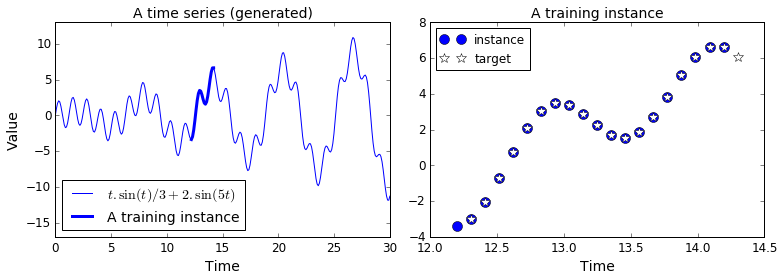

In [40]:
t = np.linspace(t_min, t_max, int((t_max - t_min) / resolution))

n_steps = 20
t_instance = np.linspace(12.2, 12.2 + resolution * (n_steps + 1), n_steps + 1)

plt.figure(figsize=(11,4))
plt.subplot(121)
plt.title("A time series (generated)", fontsize=14)
plt.plot(t, time_series(t), label=r"$t . \sin(t) / 3 + 2 . \sin(5t)$")
plt.plot(t_instance[:-1], time_series(t_instance[:-1]), "b-", linewidth=3, label="A training instance")
plt.legend(loc="lower left", fontsize=14)
plt.axis([0, 30, -17, 13])
plt.xlabel("Time")
plt.ylabel("Value")

plt.subplot(122)
plt.title("A training instance", fontsize=14)
plt.plot(t_instance[:-1], time_series(t_instance[:-1]), "bo", markersize=10, label="instance")
plt.plot(t_instance[1:], time_series(t_instance[1:]), "w*", markersize=10, label="target")
plt.legend(loc="upper left")
plt.xlabel("Time")


save_fig("time_series_plot")
plt.show()

In [41]:
X_batch, y_batch = next_batch(1, n_steps)

In [42]:
np.c_[X_batch[0], y_batch[0]]

array([[ 3.99711896,  4.42605082],
       [ 4.42605082,  4.67138363],
       [ 4.67138363,  4.53085825],
       [ 4.53085825,  3.8877217 ],
       [ 3.8877217 ,  2.74075883],
       [ 2.74075883,  1.20612611],
       [ 1.20612611, -0.50947652],
       [-0.50947652, -2.15774285],
       [-2.15774285, -3.50784175],
       [-3.50784175, -4.4011945 ],
       [-4.4011945 , -4.7885542 ],
       [-4.7885542 , -4.7403267 ],
       [-4.7403267 , -4.42762383],
       [-4.42762383, -4.07870547],
       [-4.07870547, -3.92149231],
       [-3.92149231, -4.12624098],
       [-4.12624098, -4.76243294],
       [-4.76243294, -5.7804475 ],
       [-5.7804475 , -7.02252044],
       [-7.02252044, -8.26031845]])

## Using an `OuputProjectionWrapper`

Let's create the RNN. It will contain 100 recurrent neurons and we will unroll it over 20 time steps since each traiing instance will be 20 inputs long. Each input will contain only one feature (the value at that time). The targets are also sequences of 20 inputs, each containing a sigle value:

In [43]:
tf.reset_default_graph()

n_steps = 20
n_inputs = 1
n_neurons = 100
n_outputs = 1

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.float32, [None, n_steps, n_outputs])

cell = tf.contrib.rnn.BasicRNNCell(num_units=n_neurons, activation=tf.nn.relu)
outputs, states = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32)

At each time step we now have an output vector of size 100. But what we actually want is a single output value at each time step. The simplest solution is to wrap the cell in an `OutputProjectionWrapper`.

In [44]:
tf.reset_default_graph()

n_steps = 20
n_inputs = 1
n_neurons = 100
n_outputs = 1

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.float32, [None, n_steps, n_outputs])

In [45]:
cell = tf.contrib.rnn.OutputProjectionWrapper(
    tf.contrib.rnn.BasicRNNCell(num_units=n_neurons, activation=tf.nn.relu),
    output_size=n_outputs)

In [46]:
outputs, states = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32)

In [47]:
learning_rate = 0.001

loss = tf.reduce_mean(tf.square(outputs - y)) # MSE
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()

In [48]:
saver = tf.train.Saver()

In [49]:
n_iterations = 1500
batch_size = 50

with tf.Session() as sess:
    init.run()
    for iteration in range(n_iterations):
        X_batch, y_batch = next_batch(batch_size, n_steps)
        sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        if iteration % 100 == 0:
            mse = loss.eval(feed_dict={X: X_batch, y: y_batch})
            print(iteration, "\tMSE:", mse)
    
    saver.save(sess, "./my_time_series_model") # not shown in the book

0 	MSE: 12.5781
100 	MSE: 0.547315
200 	MSE: 0.184477
300 	MSE: 0.0903497
400 	MSE: 0.0818634
500 	MSE: 0.0419608
600 	MSE: 0.0585126
700 	MSE: 0.0592046
800 	MSE: 0.0534744
900 	MSE: 0.0471234
1000 	MSE: 0.0530561
1100 	MSE: 0.0418988
1200 	MSE: 0.0444884
1300 	MSE: 0.0483815
1400 	MSE: 0.0423761


In [50]:
with tf.Session() as sess:                          # not shown in the book
    saver.restore(sess, "./my_time_series_model")   # not shown

    X_new = time_series(np.array(t_instance[:-1].reshape(-1, n_steps, n_inputs)))
    y_pred = sess.run(outputs, feed_dict={X: X_new})

INFO:tensorflow:Restoring parameters from ./my_time_series_model


In [51]:
y_pred

array([[[-3.44862223],
        [-2.45397472],
        [-1.17047215],
        [ 0.69015497],
        [ 2.09089303],
        [ 3.09212542],
        [ 3.38644886],
        [ 3.39212108],
        [ 2.87099624],
        [ 2.22925496],
        [ 1.68792105],
        [ 1.53225946],
        [ 1.85546851],
        [ 2.74033833],
        [ 3.88769126],
        [ 5.0760498 ],
        [ 6.01084471],
        [ 6.65660477],
        [ 6.67408991],
        [ 6.07125759]]], dtype=float32)

Saving figure time_series_pred_plot


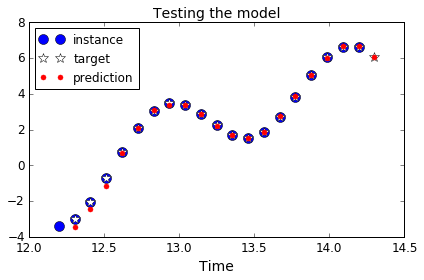

In [52]:
plt.title("Testing the model", fontsize=14)
plt.plot(t_instance[:-1], time_series(t_instance[:-1]), "bo", markersize=10, label="instance")
plt.plot(t_instance[1:], time_series(t_instance[1:]), "w*", markersize=10, label="target")
plt.plot(t_instance[1:], y_pred[0,:,0], "r.", markersize=10, label="prediction")
plt.legend(loc="upper left")
plt.xlabel("Time")

save_fig("time_series_pred_plot")
plt.show()

## Without using an `OutputProjectionWrapper`

In [53]:
tf.reset_default_graph()

n_steps = 20
n_inputs = 1
n_neurons = 100

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.float32, [None, n_steps, n_outputs])

In [54]:
cell = tf.contrib.rnn.BasicRNNCell(num_units=n_neurons, activation=tf.nn.relu)
rnn_outputs, states = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32)

In [55]:
n_outputs = 1
learning_rate = 0.001

In [56]:
stacked_rnn_outputs = tf.reshape(rnn_outputs, [-1, n_neurons])
stacked_outputs = tf.layers.dense(stacked_rnn_outputs, n_outputs)
outputs = tf.reshape(stacked_outputs, [-1, n_steps, n_outputs])

In [57]:
loss = tf.reduce_mean(tf.square(outputs - y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [58]:
n_iterations = 1500
batch_size = 50

with tf.Session() as sess:
    init.run()
    for iteration in range(n_iterations):
        X_batch, y_batch = next_batch(batch_size, n_steps)
        sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        if iteration % 100 == 0:
            mse = loss.eval(feed_dict={X: X_batch, y: y_batch})
            print(iteration, "\tMSE:", mse)
    
    X_new = time_series(np.array(t_instance[:-1].reshape(-1, n_steps, n_inputs)))
    y_pred = sess.run(outputs, feed_dict={X: X_new})
    
    saver.save(sess, "./my_time_series_model")

0 	MSE: 13.7628
100 	MSE: 0.497152
200 	MSE: 0.158743
300 	MSE: 0.0830925
400 	MSE: 0.0534122
500 	MSE: 0.0579881
600 	MSE: 0.0503276
700 	MSE: 0.0500856
800 	MSE: 0.0553265
900 	MSE: 0.0521492
1000 	MSE: 0.0520231
1100 	MSE: 0.0592064
1200 	MSE: 0.0437843
1300 	MSE: 0.0451353
1400 	MSE: 0.0390866


In [59]:
y_pred

array([[[-3.42541599],
        [-2.47213984],
        [-1.18770957],
        [ 0.65560889],
        [ 2.28769326],
        [ 3.15006804],
        [ 3.36928892],
        [ 3.1990695 ],
        [ 2.78958797],
        [ 2.17565632],
        [ 1.6632216 ],
        [ 1.44775581],
        [ 1.79704356],
        [ 2.62301469],
        [ 3.84780502],
        [ 5.08452415],
        [ 6.05238008],
        [ 6.56187773],
        [ 6.58187437],
        [ 6.04165268]]], dtype=float32)

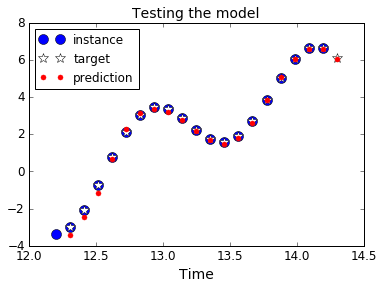

In [60]:
plt.title("Testing the model", fontsize=14)
plt.plot(t_instance[:-1], time_series(t_instance[:-1]), "bo", markersize=10, label="instance")
plt.plot(t_instance[1:], time_series(t_instance[1:]), "w*", markersize=10, label="target")
plt.plot(t_instance[1:], y_pred[0,:,0], "r.", markersize=10, label="prediction")
plt.legend(loc="upper left")
plt.xlabel("Time")

plt.show()

## Generating a creative new sequence

In [61]:
with tf.Session() as sess:                        # not shown in the book
    saver.restore(sess, "./my_time_series_model") # not shown

    sequence = [0.] * n_steps
    for iteration in range(300):
        X_batch = np.array(sequence[-n_steps:]).reshape(1, n_steps, 1)
        y_pred = sess.run(outputs, feed_dict={X: X_batch})
        sequence.append(y_pred[0, -1, 0])

INFO:tensorflow:Restoring parameters from ./my_time_series_model


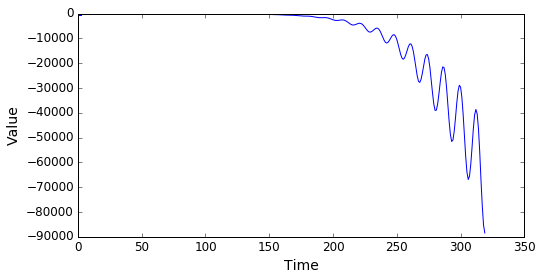

In [62]:
plt.figure(figsize=(8,4))
plt.plot(np.arange(len(sequence)), sequence, "b-")
plt.plot(t[:n_steps], sequence[:n_steps], "b-", linewidth=3)
plt.xlabel("Time")
plt.ylabel("Value")
plt.show()

INFO:tensorflow:Restoring parameters from ./my_time_series_model
Saving figure creative_sequence_plot


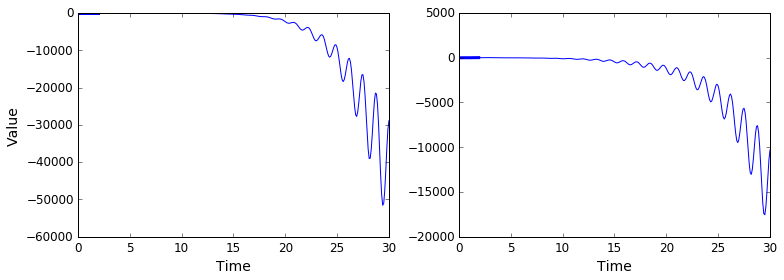

In [63]:
with tf.Session() as sess:
    saver.restore(sess, "./my_time_series_model")

    sequence1 = [0. for i in range(n_steps)]
    for iteration in range(len(t) - n_steps):
        X_batch = np.array(sequence1[-n_steps:]).reshape(1, n_steps, 1)
        y_pred = sess.run(outputs, feed_dict={X: X_batch})
        sequence1.append(y_pred[0, -1, 0])

    sequence2 = [time_series(i * resolution + t_min + (t_max-t_min/3)) for i in range(n_steps)]
    for iteration in range(len(t) - n_steps):
        X_batch = np.array(sequence2[-n_steps:]).reshape(1, n_steps, 1)
        y_pred = sess.run(outputs, feed_dict={X: X_batch})
        sequence2.append(y_pred[0, -1, 0])

plt.figure(figsize=(11,4))
plt.subplot(121)
plt.plot(t, sequence1, "b-")
plt.plot(t[:n_steps], sequence1[:n_steps], "b-", linewidth=3)
plt.xlabel("Time")
plt.ylabel("Value")

plt.subplot(122)
plt.plot(t, sequence2, "b-")
plt.plot(t[:n_steps], sequence2[:n_steps], "b-", linewidth=3)
plt.xlabel("Time")
save_fig("creative_sequence_plot")
plt.show()

# Deep RNN

## MultiRNNCell

In [64]:
tf.reset_default_graph()

n_inputs = 2
n_steps = 5

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])

In [65]:
n_neurons = 100
n_layers = 3

layers = [tf.contrib.rnn.BasicRNNCell(num_units=n_neurons)
          for layer in range(n_layers)]
multi_layer_cell = tf.contrib.rnn.MultiRNNCell(layers)
outputs, states = tf.nn.dynamic_rnn(multi_layer_cell, X, dtype=tf.float32)

In [66]:
init = tf.global_variables_initializer()

In [67]:
X_batch = rnd.rand(2, n_steps, n_inputs)

In [68]:
with tf.Session() as sess:
    init.run()
    outputs_val, states_val = sess.run([outputs, states], feed_dict={X: X_batch})

In [69]:
outputs_val.shape

(2, 5, 100)

## Distributing a Deep RNN Across Multiple GPUs

Do **NOT** do this:

In [70]:
with tf.device("/gpu:0"):  # BAD! This is ignored.
    layer1 = tf.contrib.rnn.BasicRNNCell(num_units=n_neurons)

with tf.device("/gpu:1"):  # BAD! Ignored again.
    layer2 = tf.contrib.rnn.BasicRNNCell(num_units=n_neurons)

Instead, you need a `DeviceCellWrapper`:

In [71]:
import tensorflow as tf

class DeviceCellWrapper(tf.contrib.rnn.RNNCell):
  def __init__(self, device, cell):
    self._cell = cell
    self._device = device

  @property
  def state_size(self):
    return self._cell.state_size

  @property
  def output_size(self):
    return self._cell.output_size

  def __call__(self, inputs, state, scope=None):
    with tf.device(self._device):
        return self._cell(inputs, state, scope)

In [72]:
tf.reset_default_graph()

n_inputs = 5
n_steps = 20
n_neurons = 100

X = tf.placeholder(tf.float32, shape=[None, n_steps, n_inputs])

In [73]:
devices = ["/cpu:0", "/cpu:0", "/cpu:0"] # replace with ["/gpu:0", "/gpu:1", "/gpu:2"] if you have 3 GPUs
cells = [DeviceCellWrapper(dev,tf.contrib.rnn.BasicRNNCell(num_units=n_neurons))
         for dev in devices]
multi_layer_cell = tf.contrib.rnn.MultiRNNCell(cells)
outputs, states = tf.nn.dynamic_rnn(multi_layer_cell, X, dtype=tf.float32)

In [74]:
init = tf.global_variables_initializer()

In [75]:
with tf.Session() as sess:
    init.run()
    print(sess.run(outputs, feed_dict={X: rnd.rand(2, n_steps, n_inputs)}))

[[[ -4.02673557e-02  -1.32697192e-03   5.89309596e-02 ...,   3.01364507e-03
     1.13810204e-01  -2.95128021e-03]
  [  5.07392362e-02  -2.27102004e-02   9.08590779e-02 ...,  -7.28313485e-03
     7.38209486e-02  -1.04581699e-01]
  [ -2.63734370e-01   7.45113939e-02  -1.59692034e-01 ...,  -2.26709619e-02
     1.94620773e-01  -2.74280488e-01]
  ..., 
  [ -1.57276452e-01  -2.25722805e-01  -2.83314496e-01 ...,  -2.01246798e-01
    -2.75413662e-01  -3.03873122e-01]
  [ -2.17203677e-01  -1.56792626e-01  -8.67026821e-02 ...,  -1.56499967e-02
    -2.58552223e-01   1.44222811e-01]
  [ -2.23659739e-01  -1.20433375e-01  -1.25079557e-01 ...,  -9.19605419e-02
    -2.63631225e-01  -5.52971773e-02]]

 [[ -7.01689422e-02   7.87304118e-02  -4.61662567e-04 ...,  -7.18819797e-02
     1.39971092e-01  -1.15815736e-01]
  [ -8.13159868e-02   3.60450037e-02   9.81829762e-02 ...,   1.03328772e-01
     7.71655664e-02  -1.34362206e-01]
  [ -8.32017362e-02   4.47433516e-02   5.96695021e-02 ...,  -2.00068895e-02
  

## Dropout

In [76]:
tf.reset_default_graph()

n_inputs = 1
n_neurons = 100
n_layers = 3
n_steps = 20
n_outputs = 1

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.float32, [None, n_steps, n_outputs])

In [77]:
keep_prob = 0.5

cells = [tf.contrib.rnn.BasicRNNCell(num_units=n_neurons)
         for layer in range(n_layers)]
cells_drop = [tf.contrib.rnn.DropoutWrapper(cell, input_keep_prob=keep_prob)
              for cell in cells]
multi_layer_cell = tf.contrib.rnn.MultiRNNCell(cells_drop)
rnn_outputs, states = tf.nn.dynamic_rnn(multi_layer_cell, X, dtype=tf.float32)

In [78]:
learning_rate = 0.01

stacked_rnn_outputs = tf.reshape(rnn_outputs, [-1, n_neurons])
stacked_outputs = tf.layers.dense(stacked_rnn_outputs, n_outputs)
outputs = tf.reshape(stacked_outputs, [-1, n_steps, n_outputs])

loss = tf.reduce_mean(tf.square(outputs - y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()
saver = tf.train.Saver()

Unfortunately, this code is only usable for training, because the `DropoutWrapper` class has no `training` parameter, so it always applies dropout, even when the model is not being trained, so we must first train the model, then create a different model for testing, without the `DropoutWrapper`.

In [79]:
n_iterations = 1000
batch_size = 50

with tf.Session() as sess:
    init.run()
    for iteration in range(n_iterations):
        X_batch, y_batch = next_batch(batch_size, n_steps)
        _, mse = sess.run([training_op, loss], feed_dict={X: X_batch, y: y_batch})
        if iteration % 100 == 0:
            print(iteration, "Training MSE:", mse)
    
    saver.save(sess, "./my_dropout_time_series_model")

0 Training MSE: 19.0452
100 Training MSE: 5.08043
200 Training MSE: 3.33357
300 Training MSE: 4.07959
400 Training MSE: 2.8691
500 Training MSE: 3.28825
600 Training MSE: 3.5159
700 Training MSE: 3.04527
800 Training MSE: 3.65255
900 Training MSE: 2.37376


Now that the model is trained, we need to create the model again, but without the `DropoutWrapper` for testing:

In [80]:
tf.reset_default_graph()

n_inputs = 1
n_neurons = 100
n_layers = 3
n_steps = 20
n_outputs = 1

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.float32, [None, n_steps, n_outputs])

keep_prob = 0.5

cells = [tf.contrib.rnn.BasicRNNCell(num_units=n_neurons)
         for layer in range(n_layers)]
multi_layer_cell = tf.contrib.rnn.MultiRNNCell(cells)
rnn_outputs, states = tf.nn.dynamic_rnn(multi_layer_cell, X, dtype=tf.float32)

learning_rate = 0.01

stacked_rnn_outputs = tf.reshape(rnn_outputs, [-1, n_neurons])
stacked_outputs = tf.layers.dense(stacked_rnn_outputs, n_outputs)
outputs = tf.reshape(stacked_outputs, [-1, n_steps, n_outputs])

loss = tf.reduce_mean(tf.square(outputs - y))

init = tf.global_variables_initializer()
saver = tf.train.Saver()

INFO:tensorflow:Restoring parameters from ./my_dropout_time_series_model


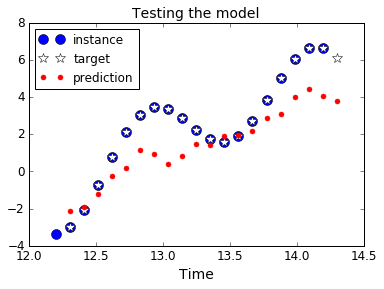

In [81]:
with tf.Session() as sess:
    saver.restore(sess, "./my_dropout_time_series_model")

    X_new = time_series(np.array(t_instance[:-1].reshape(-1, n_steps, n_inputs)))
    y_pred = sess.run(outputs, feed_dict={X: X_new})

plt.title("Testing the model", fontsize=14)
plt.plot(t_instance[:-1], time_series(t_instance[:-1]), "bo", markersize=10, label="instance")
plt.plot(t_instance[1:], time_series(t_instance[1:]), "w*", markersize=10, label="target")
plt.plot(t_instance[1:], y_pred[0,:,0], "r.", markersize=10, label="prediction")
plt.legend(loc="upper left")
plt.xlabel("Time")

plt.show()

Oops, it seems that Dropout does not help at all in this particular case. :/

Another option is to write a script with a command line argument to specify whether you want to train the mode or use it for making predictions:

In [82]:
tf.reset_default_graph()

import sys
training = True  # in a script, this would be (sys.argv[-1] == "train") instead

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.float32, [None, n_steps, n_outputs])

cells = [tf.contrib.rnn.BasicRNNCell(num_units=n_neurons)
         for layer in range(n_layers)]
if training:
    cells = [tf.contrib.rnn.DropoutWrapper(cell, input_keep_prob=keep_prob)
             for cell in cells]
multi_layer_cell = tf.contrib.rnn.MultiRNNCell(cells)
rnn_outputs, states = tf.nn.dynamic_rnn(multi_layer_cell, X, dtype=tf.float32)

stacked_rnn_outputs = tf.reshape(rnn_outputs, [-1, n_neurons])    # not shown in the book
stacked_outputs = tf.layers.dense(stacked_rnn_outputs, n_outputs) # not shown
outputs = tf.reshape(stacked_outputs, [-1, n_steps, n_outputs])   # not shown
loss = tf.reduce_mean(tf.square(outputs - y))                     # not shown
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)   # not shown
training_op = optimizer.minimize(loss)                            # not shown
init = tf.global_variables_initializer()                          # not shown
saver = tf.train.Saver()                                          # not shown

with tf.Session() as sess:
    if training:
        init.run()
        for iteration in range(n_iterations):
            X_batch, y_batch = next_batch(batch_size, n_steps)    # not shown
            _, mse = sess.run([training_op, loss], feed_dict={X: X_batch, y: y_batch}) # not shown
            if iteration % 100 == 0:                              # not shown
                print(iteration, "Training MSE:", mse)            # not shown
        save_path = saver.save(sess, "/tmp/my_model.ckpt")
    else:
        saver.restore(sess, "/tmp/my_model.ckpt")
        X_new = time_series(np.array(t_instance[:-1].reshape(-1, n_steps, n_inputs))) # not shown
        y_pred = sess.run(outputs, feed_dict={X: X_new})                              # not shown

0 Training MSE: 18.5711
100 Training MSE: 5.00803
200 Training MSE: 3.57105
300 Training MSE: 4.78687
400 Training MSE: 3.2551
500 Training MSE: 3.66258
600 Training MSE: 2.91071
700 Training MSE: 3.82467
800 Training MSE: 3.92405
900 Training MSE: 3.27747


# LSTM

In [83]:
lstm_cell = tf.contrib.rnn.BasicLSTMCell(num_units=n_neurons)

In [84]:
tf.reset_default_graph()

n_steps = 28
n_inputs = 28
n_neurons = 150
n_outputs = 10
n_layers = 3

learning_rate = 0.001

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.int32, [None])

lstm_cells = [tf.contrib.rnn.BasicLSTMCell(num_units=n_neurons)
              for layer in range(n_layers)]
multi_cell = tf.contrib.rnn.MultiRNNCell(lstm_cells)
outputs, states = tf.nn.dynamic_rnn(multi_cell, X, dtype=tf.float32)
top_layer_h_state = states[-1][1]
logits = tf.layers.dense(top_layer_h_state, n_outputs, name="softmax")
xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
loss = tf.reduce_mean(xentropy, name="loss")
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)
correct = tf.nn.in_top_k(logits, y, 1)
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))
    
init = tf.global_variables_initializer()

In [85]:
states

(LSTMStateTuple(c=<tf.Tensor 'rnn/while/Exit_2:0' shape=(?, 150) dtype=float32>, h=<tf.Tensor 'rnn/while/Exit_3:0' shape=(?, 150) dtype=float32>),
 LSTMStateTuple(c=<tf.Tensor 'rnn/while/Exit_4:0' shape=(?, 150) dtype=float32>, h=<tf.Tensor 'rnn/while/Exit_5:0' shape=(?, 150) dtype=float32>),
 LSTMStateTuple(c=<tf.Tensor 'rnn/while/Exit_6:0' shape=(?, 150) dtype=float32>, h=<tf.Tensor 'rnn/while/Exit_7:0' shape=(?, 150) dtype=float32>))

In [86]:
top_layer_h_state

<tf.Tensor 'rnn/while/Exit_7:0' shape=(?, 150) dtype=float32>

In [87]:
n_epochs = 10
batch_size = 150

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for iteration in range(mnist.train.num_examples // batch_size):
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            X_batch = X_batch.reshape((batch_size, n_steps, n_inputs))
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        acc_train = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        acc_test = accuracy.eval(feed_dict={X: X_test, y: y_test})
        print("Epoch", epoch, "Train accuracy =", acc_train, "Test accuracy =", acc_test)

Epoch 0 Train accuracy = 0.98 Test accuracy = 0.9564
Epoch 1 Train accuracy = 0.98 Test accuracy = 0.9647
Epoch 2 Train accuracy = 0.98 Test accuracy = 0.9733
Epoch 3 Train accuracy = 1.0 Test accuracy = 0.9809
Epoch 4 Train accuracy = 1.0 Test accuracy = 0.9788
Epoch 5 Train accuracy = 0.993333 Test accuracy = 0.9864
Epoch 6 Train accuracy = 0.993333 Test accuracy = 0.9873
Epoch 7 Train accuracy = 0.993333 Test accuracy = 0.987
Epoch 8 Train accuracy = 0.993333 Test accuracy = 0.9851
Epoch 9 Train accuracy = 1.0 Test accuracy = 0.9848


In [88]:
lstm_cell = tf.contrib.rnn.LSTMCell(num_units=n_neurons, use_peepholes=True)

In [89]:
gru_cell = tf.contrib.rnn.GRUCell(num_units=n_neurons)

# Embeddings

This section is based on TensorFlow's [Word2Vec tutorial](https://www.tensorflow.org/versions/r0.11/tutorials/word2vec/index.html).

## Fetch the data

In [90]:
from six.moves import urllib

import errno
import os
import zipfile

WORDS_PATH = "datasets/words"
WORDS_URL = 'http://mattmahoney.net/dc/text8.zip'

def mkdir_p(path):
    """Create directories, ok if they already exist.
    
    This is for python 2 support. In python >=3.2, simply use:
    >>> os.makedirs(path, exist_ok=True)
    """
    try:
        os.makedirs(path)
    except OSError as exc:
        if exc.errno == errno.EEXIST and os.path.isdir(path):
            pass
        else:
            raise

def fetch_words_data(words_url=WORDS_URL, words_path=WORDS_PATH):
    os.makedirs(words_path, exist_ok=True)
    zip_path = os.path.join(words_path, "words.zip")
    if not os.path.exists(zip_path):
        urllib.request.urlretrieve(words_url, zip_path)
    with zipfile.ZipFile(zip_path) as f:
        data = f.read(f.namelist()[0])
    return data.decode("ascii").split()

In [91]:
words = fetch_words_data()

In [92]:
words[:5]

['anarchism', 'originated', 'as', 'a', 'term']

## Build the dictionary

In [93]:
from collections import Counter

vocabulary_size = 50000

vocabulary = [("UNK", None)] + Counter(words).most_common(vocabulary_size - 1)
vocabulary = np.array([word for word, _ in vocabulary])
dictionary = {word: code for code, word in enumerate(vocabulary)}
data = np.array([dictionary.get(word, 0) for word in words])

In [94]:
" ".join(words[:9]), data[:9]

('anarchism originated as a term of abuse first used',
 array([5237, 3082,   12,    6,  195,    2, 3134,   46,   59]))

In [95]:
" ".join([vocabulary[word_index] for word_index in [5241, 3081, 12, 6, 195, 2, 3134, 46, 59]])

'guided didn as a term of abuse first used'

In [96]:
words[24], data[24]

('culottes', 0)

## Generate batches

In [97]:
import random
from collections import deque

def generate_batch(batch_size, num_skips, skip_window):
    global data_index
    assert batch_size % num_skips == 0
    assert num_skips <= 2 * skip_window
    batch = np.ndarray(shape=(batch_size), dtype=np.int32)
    labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
    span = 2 * skip_window + 1 # [ skip_window target skip_window ]
    buffer = deque(maxlen=span)
    for _ in range(span):
        buffer.append(data[data_index])
        data_index = (data_index + 1) % len(data)
    for i in range(batch_size // num_skips):
        target = skip_window  # target label at the center of the buffer
        targets_to_avoid = [ skip_window ]
        for j in range(num_skips):
            while target in targets_to_avoid:
                target = random.randint(0, span - 1)
            targets_to_avoid.append(target)
            batch[i * num_skips + j] = buffer[skip_window]
            labels[i * num_skips + j, 0] = buffer[target]
        buffer.append(data[data_index])
        data_index = (data_index + 1) % len(data)
    return batch, labels

In [98]:
data_index=0
batch, labels = generate_batch(8, 2, 1)

In [99]:
batch, [vocabulary[word] for word in batch]

(array([3082, 3082,   12,   12,    6,    6,  195,  195], dtype=int32),
 ['originated', 'originated', 'as', 'as', 'a', 'a', 'term', 'term'])

In [100]:
labels, [vocabulary[word] for word in labels[:, 0]]

(array([[  12],
        [5237],
        [3082],
        [   6],
        [ 195],
        [  12],
        [   2],
        [   6]], dtype=int32),
 ['as', 'anarchism', 'originated', 'a', 'term', 'as', 'of', 'a'])

## Build the model

In [101]:
batch_size = 128
embedding_size = 128  # Dimension of the embedding vector.
skip_window = 1       # How many words to consider left and right.
num_skips = 2         # How many times to reuse an input to generate a label.

# We pick a random validation set to sample nearest neighbors. Here we limit the
# validation samples to the words that have a low numeric ID, which by
# construction are also the most frequent.
valid_size = 16     # Random set of words to evaluate similarity on.
valid_window = 100  # Only pick dev samples in the head of the distribution.
valid_examples = rnd.choice(valid_window, valid_size, replace=False)
num_sampled = 64    # Number of negative examples to sample.

learning_rate = 0.01

In [102]:
tf.reset_default_graph()

# Input data.
train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
valid_dataset = tf.constant(valid_examples, dtype=tf.int32)

In [103]:
vocabulary_size = 50000
embedding_size = 150

# Look up embeddings for inputs.
init_embeds = tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0)
embeddings = tf.Variable(init_embeds)

In [104]:
train_inputs = tf.placeholder(tf.int32, shape=[None])
embed = tf.nn.embedding_lookup(embeddings, train_inputs)

In [105]:
# Construct the variables for the NCE loss
nce_weights = tf.Variable(
    tf.truncated_normal([vocabulary_size, embedding_size],
                        stddev=1.0 / np.sqrt(embedding_size)))
nce_biases = tf.Variable(tf.zeros([vocabulary_size]))

# Compute the average NCE loss for the batch.
# tf.nce_loss automatically draws a new sample of the negative labels each
# time we evaluate the loss.
loss = tf.reduce_mean(
    tf.nn.nce_loss(nce_weights, nce_biases, train_labels, embed,
                   num_sampled, vocabulary_size))

# Construct the Adam optimizer
optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(loss)

# Compute the cosine similarity between minibatch examples and all embeddings.
norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), axis=1, keep_dims=True))
normalized_embeddings = embeddings / norm
valid_embeddings = tf.nn.embedding_lookup(normalized_embeddings, valid_dataset)
similarity = tf.matmul(valid_embeddings, normalized_embeddings, transpose_b=True)

# Add variable initializer.
init = tf.global_variables_initializer()

## Train the model

In [106]:
num_steps = 10001

with tf.Session() as session:
    init.run()

    average_loss = 0
    for step in range(num_steps):
        print("\rIteration: {}".format(step), end="\t")
        batch_inputs, batch_labels = generate_batch(batch_size, num_skips, skip_window)
        feed_dict = {train_inputs : batch_inputs, train_labels : batch_labels}

        # We perform one update step by evaluating the training op (including it
        # in the list of returned values for session.run()
        _, loss_val = session.run([training_op, loss], feed_dict=feed_dict)
        average_loss += loss_val

        if step % 2000 == 0:
            if step > 0:
                average_loss /= 2000
            # The average loss is an estimate of the loss over the last 2000 batches.
            print("Average loss at step ", step, ": ", average_loss)
            average_loss = 0

        # Note that this is expensive (~20% slowdown if computed every 500 steps)
        if step % 10000 == 0:
            sim = similarity.eval()
            for i in range(valid_size):
                valid_word = vocabulary[valid_examples[i]]
                top_k = 8 # number of nearest neighbors
                nearest = (-sim[i, :]).argsort()[1:top_k+1]
                log_str = "Nearest to %s:" % valid_word
                for k in range(top_k):
                    close_word = vocabulary[nearest[k]]
                    log_str = "%s %s," % (log_str, close_word)
                print(log_str)

    final_embeddings = normalized_embeddings.eval()

Iteration: 0	Average loss at step  0 :  276.952941895
Nearest to i: cathar, binder, rout, applying, plastic, atlantis, panini, detainee,
Nearest to states: pekah, tempered, fournier, dantzig, tangents, manual, ephraem, tollens,
Nearest to war: hacker, mamet, scaled, fearless, progressives, born, duvalier, dirkjan,
Nearest to however: enfield, capitals, stunning, tbilisi, ghibli, antonine, creutzfeldt, garp,
Nearest to by: bagapsh, dry, agenda, whiteface, untouched, doctrinal, libels, pete,
Nearest to only: langmuir, cherokee, schneider, rawlinson, intoxicated, radiometric, adair, midlands,
Nearest to into: kword, abstractly, copenhagen, psa, goalkeepers, bernardino, nicolau, wong,
Nearest to he: athabasca, lutheran, bess, bootlegs, bro, dramatists, conjugate, organ,
Nearest to may: agilent, flows, sandstorms, jain, microbial, eduardo, intercal, swampy,
Nearest to two: negotiator, anastasia, benford, mercantile, ambulance, goidelic, planckian, classmate,
Nearest to so: norepinephrine, r

Let's save the final embeddings (of course you can use a TensorFlow `Saver` if you prefer):

In [107]:
np.save("./my_final_embeddings.npy", final_embeddings)

## Plot the embeddings

In [108]:
def plot_with_labels(low_dim_embs, labels):
    assert low_dim_embs.shape[0] >= len(labels), "More labels than embeddings"
    plt.figure(figsize=(18, 18))  #in inches
    for i, label in enumerate(labels):
        x, y = low_dim_embs[i,:]
        plt.scatter(x, y)
        plt.annotate(label,
                     xy=(x, y),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')

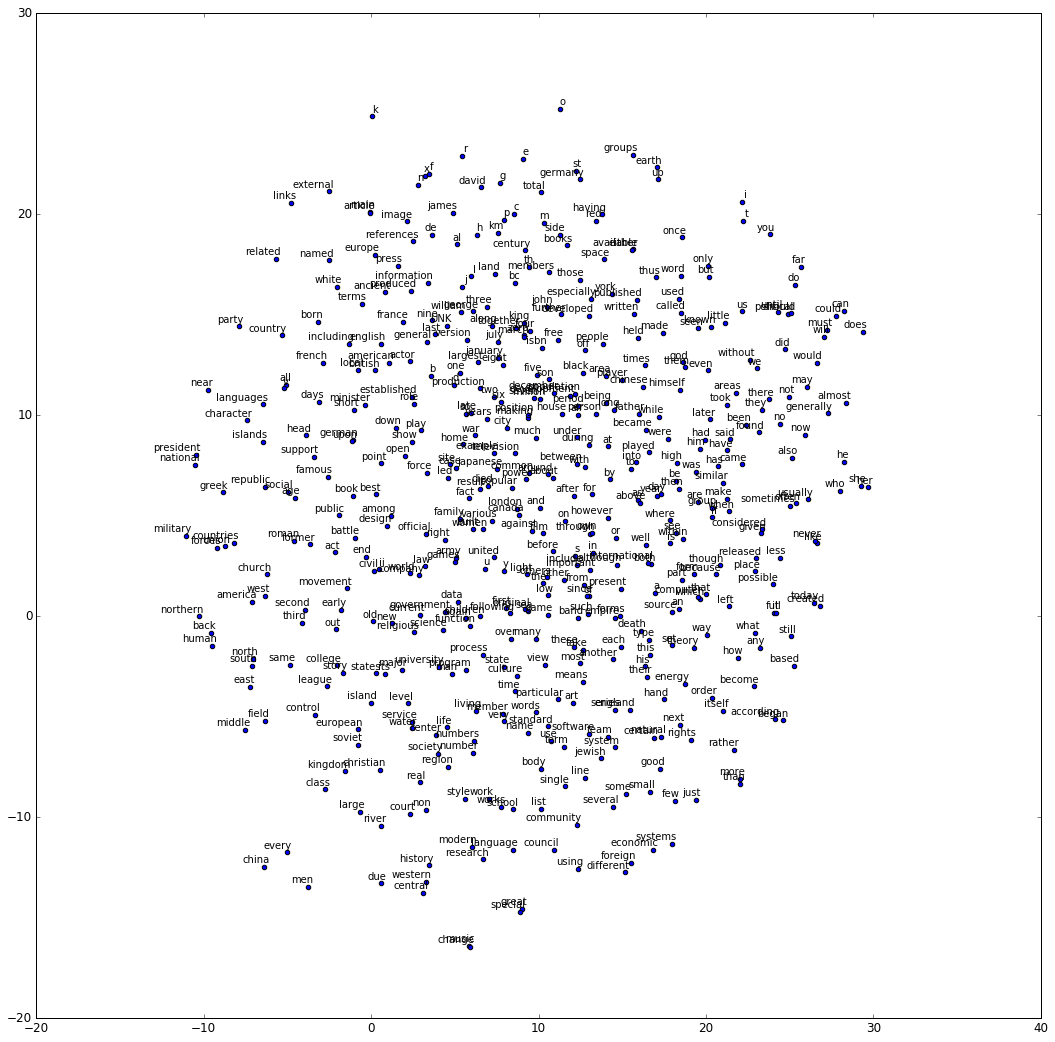

In [109]:
from sklearn.manifold import TSNE

tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
plot_only = 500
low_dim_embs = tsne.fit_transform(final_embeddings[:plot_only,:])
labels = [vocabulary[i] for i in range(plot_only)]
plot_with_labels(low_dim_embs, labels)

# Machine Translation

The `basic_rnn_seq2seq()` function creates a simple Encoder/Decoder model: it first runs an RNN to encode `encoder_inputs` into a state vector, then runs a decoder initialized with the last encoder state on `decoder_inputs`. Encoder and decoder use the same RNN cell type but they don't share parameters.

In [111]:
import tensorflow as tf
tf.reset_default_graph()

n_steps = 50
n_neurons = 200
n_layers = 3
num_encoder_symbols = 20000
num_decoder_symbols = 20000
embedding_size = 150
learning_rate = 0.01

X = tf.placeholder(tf.int32, [None, n_steps]) # English sentences
Y = tf.placeholder(tf.int32, [None, n_steps]) # French translations
W = tf.placeholder(tf.float32, [None, n_steps - 1, 1])
Y_input = Y[:, :-1]
Y_target = Y[:, 1:]

encoder_inputs = tf.unstack(tf.transpose(X)) # list of 1D tensors
decoder_inputs = tf.unstack(tf.transpose(Y_input)) # list of 1D tensors

lstm_cells = [tf.contrib.rnn.BasicLSTMCell(num_units=n_neurons)
              for layer in range(n_layers)]
cell = tf.contrib.rnn.MultiRNNCell(lstm_cells)

output_seqs, states = tf.contrib.legacy_seq2seq.embedding_rnn_seq2seq(
    encoder_inputs,
    decoder_inputs,
    cell,
    num_encoder_symbols,
    num_decoder_symbols,
    embedding_size)

logits = tf.transpose(tf.unstack(output_seqs), perm=[1, 0, 2])

In [112]:
logits_flat = tf.reshape(logits, [-1, num_decoder_symbols])
Y_target_flat = tf.reshape(Y_target, [-1])
W_flat = tf.reshape(W, [-1])
xentropy = W_flat * tf.nn.sparse_softmax_cross_entropy_with_logits(labels=Y_target_flat, logits=logits_flat)
loss = tf.reduce_mean(xentropy)
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()

# Exercise solutions

**Coming soon**